In [1]:
# import numpy.linalg as la
# import matplotlib as mpl
# import matplotlib.lines as mlines
# from matplotlib.patches import Ellipse
# import matplotlib.gridspec as gridspec
# import scipy.stats
# import scipy.linalg as linalg
# from scipy.stats import gaussian_kde
# from scipy.spatial.distance import squareform, pdist
# from scipy.stats import spearmanr, pearsonr, entropy
# from fastcluster import linkage
# from sklearn.preprocessing import StandardScaler
# from skimage import measure
# import torch.linalg


# Load Packages
from Functions import *
# from sklearn.datasets import load_wine
# from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
import libpysal
from esda.moran import Moran
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from itertools import combinations

# Set plot default
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams["axes.grid"] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
else:
    print("GPU is not available.")
    device = torch.device("cpu")

GPU is available.


In [3]:
# Template to load synthetic dataset
df = pd.read_csv("High_Dim_Dataset_with_Target_rho_0.csv")
target = df.iloc[:,-1].values # response
df_scaled = df.iloc[:, :4].values # predictors

# # Template to load wine dataset
# data = load_wine()
# target = load_wine().target
# df = pd.DataFrame(data.data, columns=data.feature_names)
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df)

In [4]:
# Instantiate dataset customization class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], idx

In [5]:
# Instantiate AE class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
# Set Parameters for AE and format dataset to tensor via pytorch
dataset = CustomDataset(torch.tensor(df_scaled, dtype=torch.float32))
num_epochs = 10000
batch_size = 16
lr=0.001
input_dim = df_scaled.shape[1]
encoding_dim = 2
model = Autoencoder(input_dim, encoding_dim)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
## Experiment Settings
num_seeds = num_realizations = 500 
initial_seed = 0 # starting sequence for random seed generator
random.seed(initial_seed) # Initialize starting seed to ensure random seed sequence reproducibility
step_size = 10   # Change this to increase seeds every 'x' units as needed
seed_values = [initial_seed + (step_size * i) for i in range(num_seeds)] # sequence for selecting seeds used
hdf5_file = 'embedding_realizations.h5' # store each latent space for all AE realizations here
random.seed(initial_seed)
visualization_indices = random.sample(range(num_seeds), 6)

# Load the saved results from previous runs
with open('curated_lists_corr0.pkl', 'rb') as file:
    all_loss_curves, change_percentages, convex_hull_vertices, local_anisotropies = pickle.load(file)

with open('instability_measures_corr_0.pkl', 'rb)' as file:
    instability_measures_corr_0 = pickle.load(file)

statistics_array = np.load('statistics_array_corr_0.npy')

# # Load stress and Jaccard numpy arrays
# flatten_data2 = np.load('jaccard_array_corr_0.npy')
# flatten_data1 = np.load('stress_array_corr_0.npy')
# flatten_data2_normalized = np.load('jaccard_array_corr_0_norm.npy')
# flatten_data1_normalized = np.load('stress_array_corr_0_norm.npy')

Visualize training loss for select AE realizations

The minimum loss for all AE realizations is:  0.10699


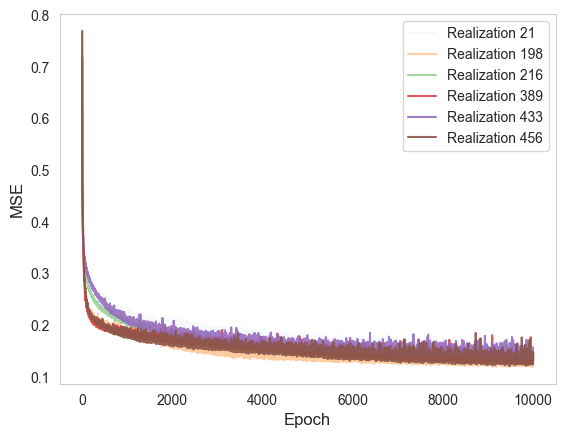

In [15]:
## Training Loss for Select AE Realizations over 10000 Epochs
loss_val = round(np.min(all_loss_curves),5)
print('The minimum loss for all AE realizations is: ',loss_val)

# Generate alpha values within the range [0, 1]
alphas = [i/num_seeds for i in range(1, num_seeds + 1)]

# Visualize loss functions for select realizations
for idx, losses in enumerate(all_loss_curves):
    if idx in visualization_indices:
        plt.plot(losses, label=f'Realization {idx+1}', alpha=alphas[idx])

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()
plt.savefig('Training loss for select realizations.tiff', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Compute the percentage changes in anchors found via convex hull
change_anchors = percentage_change(convex_hull_vertices, data_type='list')

# Compute the percentage changes in Moran's
change_moran = percentage_change(statistics_array[:,0], data_type='numpy')

# Compute the percentage changes in anisotropies found
change_mvee_anis = percentage_change(statistics_array[:,1], data_type='numpy')
change_global_anis = percentage_change(statistics_array[:,2], data_type='numpy')
change_har_anis = percentage_change(statistics_array[:,3], data_type='numpy')

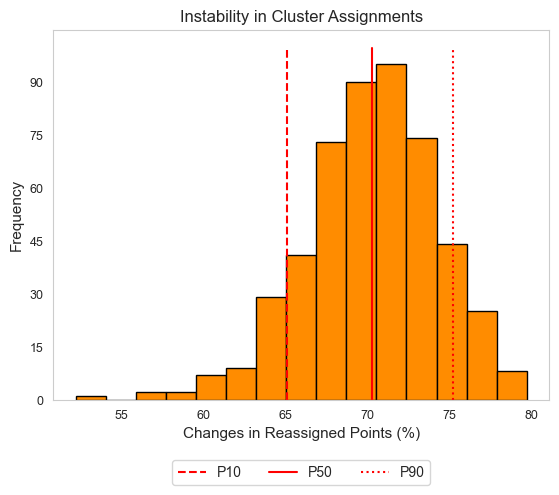

In [11]:
# Visualize changes in cluster assignement over all AE realizations
optimal_bin = knuth_bin_width(change_percentages)
plt.hist(change_percentages, bins=optimal_bin, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=plt, optimal_bin=optimal_bin, values=change_percentages, weights=np.ones(len(change_percentages)), color='red')
plt.xlabel('Changes in Reassigned Points (%)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Instability in Cluster Assignments')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(axis='both', labelsize=9)
plt.legend(loc='lower center', bbox_to_anchor=(0.50, -0.25), ncol=3)
plt.savefig('Instability in Cluster Assignemnts.tiff', dpi=300, bbox_inches='tight')
plt.show()

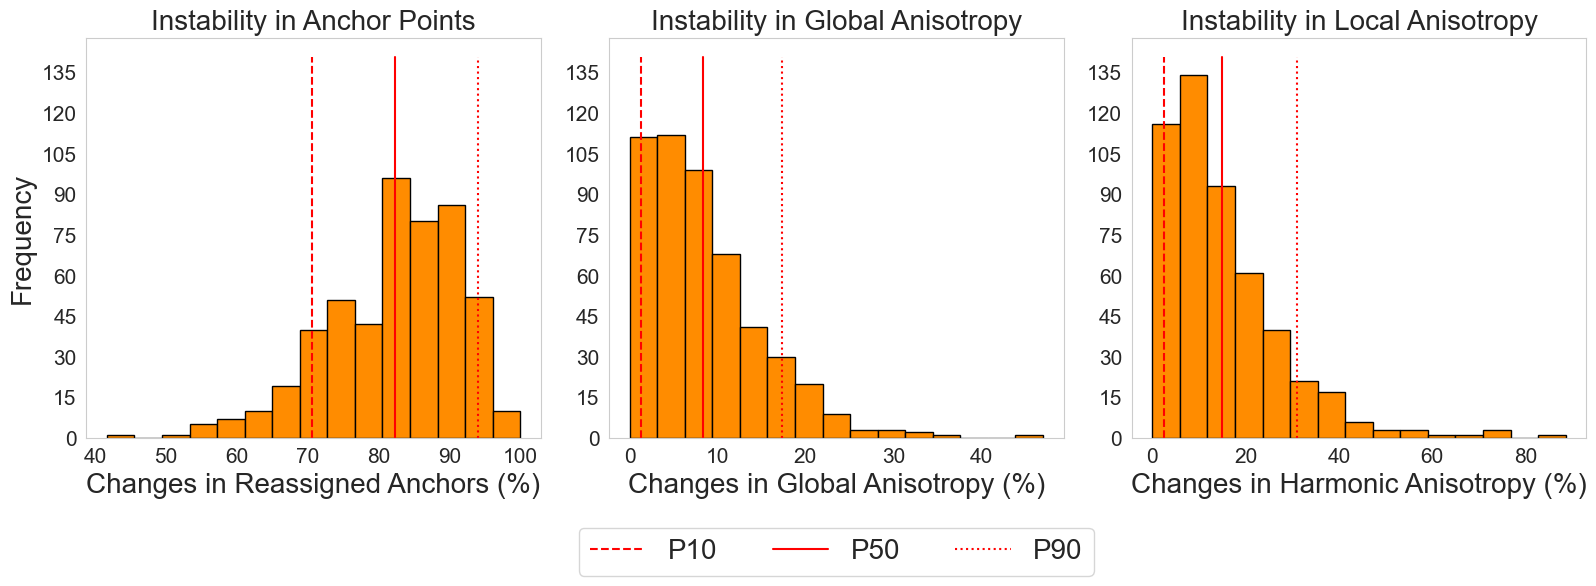

In [20]:
# Find optimal bins for each stats
optimal_bin1 = knuth_bin_width(change_anchors)
optimal_bin2 = knuth_bin_width(change_global_anis)
optimal_bin3 = knuth_bin_width(change_har_anis)

# Compute histogram data
hist_data_1, _ = np.histogram(change_anchors, bins=optimal_bin1)
hist_data_2, _ = np.histogram(change_global_anis, bins=optimal_bin2)
hist_data_3, _ = np.histogram(change_har_anis, bins=optimal_bin3)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2), max(hist_data_3))
overall_max_freq += overall_max_freq * 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 4)) #-o #8,4 ?
axs[0].hist(change_anchors, bins=optimal_bin1, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin1, values=change_anchors,weights=np.ones(len(change_anchors)), color='red', max_freq_override=overall_max_freq)
axs[0].set_xlabel('Changes in Reassigned Anchors (%)', fontsize= 20)
axs[0].set_ylabel('Frequency', fontsize= 20)
axs[0].set_title('Instability in Anchor Points', fontsize= 20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].hist(change_global_anis, bins=optimal_bin2, color='darkorange', edgecolor='black')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin2, values=change_global_anis,weights=np.ones(len(change_global_anis)),color='red', max_freq_override=overall_max_freq)
axs[1].set_xlabel('Changes in Global Anisotropy (%)', fontsize= 20)
axs[1].set_title('Instability in Global Anisotropy', fontsize= 20)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].tick_params(axis='both', labelsize=15)

axs[2].hist(change_har_anis, bins=optimal_bin3, color='darkorange', edgecolor='black') # based off F1 score computation INSPO!
histogram_bounds(ax_or_plt=axs[2], optimal_bin=optimal_bin3, values=change_har_anis,weights=np.ones(len(change_har_anis)),color='red', max_freq_override=overall_max_freq)
axs[2].set_xlabel('Changes in Harmonic Anisotropy (%)', fontsize= 20)
axs[2].set_title('Instability in Local Anisotropy', fontsize= 20)
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].tick_params(axis='both', labelsize=15)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.08), ncol=3, fontsize=20)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.15, hspace=0.3)
plt.savefig('Instability in Shape-based Statistics.tiff', dpi=300, bbox_inches='tight')
plt.show()

## Stress and Jaccard Computations

In [21]:
# Stress computation for unique pairs only
with h5py.File(hdf5_file, 'r') as f:
    N = len(f.keys())
    # Initialize matrix
    adjusted_stress_matrix = np.zeros((N, N))

    for i in range(N):
        embedding_i = f[f'embedding_realizations_{i}'][:]
        for j in range(i + 1, N):  # Starting from i + 1 to avoid redundant computations
            embedding_j = f[f'embedding_realizations_{j}'][:]

            # Compute adjusted stress
            adj_stress = adjusted_stress(embedding_i, embedding_j)
            adjusted_stress_matrix[i, j] = adj_stress
            adjusted_stress_matrix[j, i] = adj_stress

# To compare the sets of vertices from the convex hulls across different realizations, let's use set operations.
# The idea is to assess the overlap and differences between the sets of indices for each pair of AE realizations
# and compute the Jaccard dissimilarity.

comparisons = {}
for (i, vertices_i), (j, vertices_j) in combinations(enumerate(convex_hull_vertices), 2):
    set_i, set_j = set(vertices_i.tolist()), set(vertices_j.tolist())
    intersection = set_i.intersection(set_j)
    union = set_i.union(set_j)
    jaccard_similarity = len(intersection) / len(union) if union else 1
    comparisons[(i, j)] = jaccard_similarity

# Compute Jaccard similarity matrix
num_realizations = len(convex_hull_vertices)
similarity_matrix = np.zeros((num_realizations, num_realizations))

for (i, j), similarity in comparisons.items():
    similarity_matrix[i, j] = similarity
    similarity_matrix[j, i] = similarity  # Mirror the similarity as the matrix is symmetric

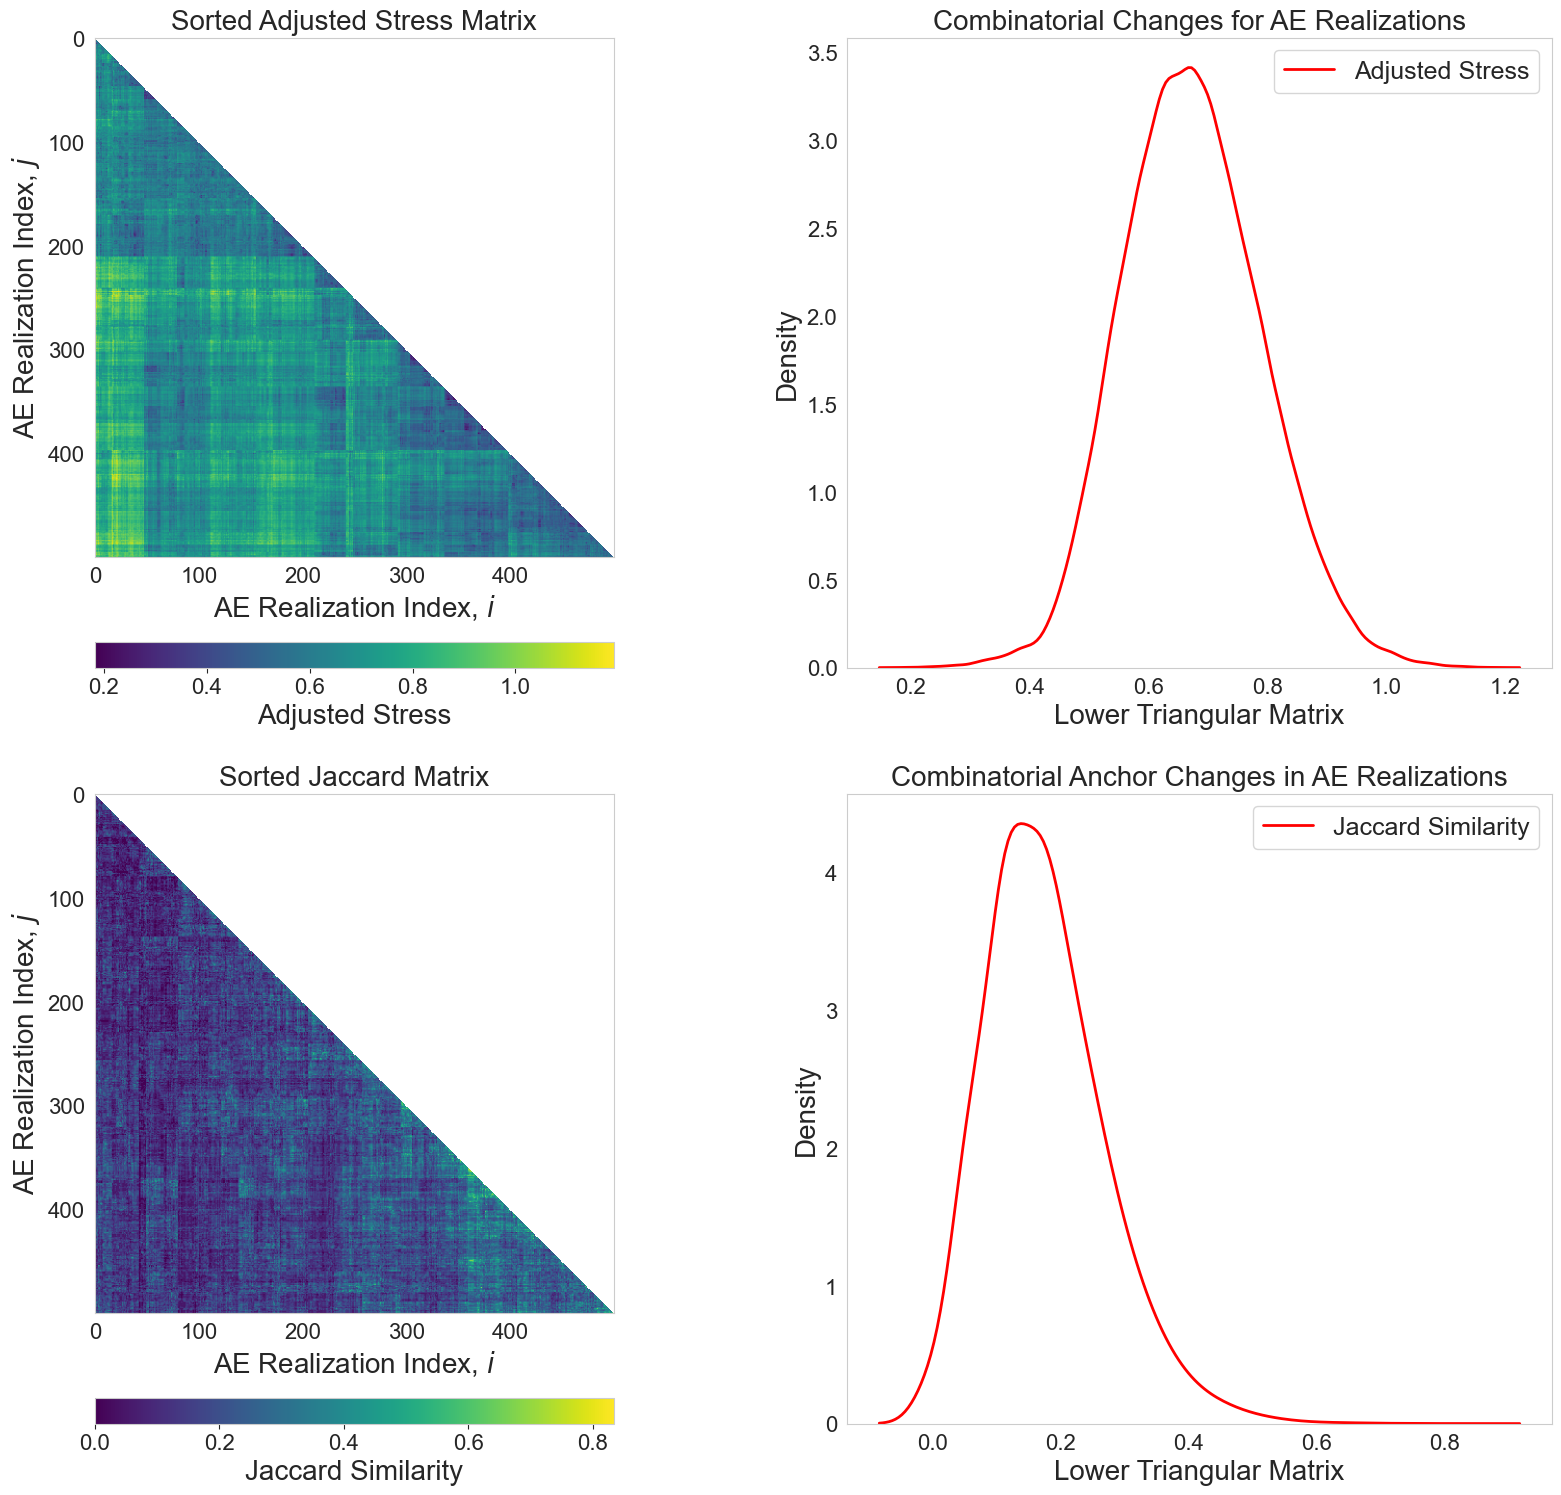

In [22]:
# Compute and Visualize stress measures
ordered_dist_mat1, res_order1, res_linkage1 = compute_serial_matrix(adjusted_stress_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle1 = np.tril(ordered_dist_mat1, k=-1) # Adjusted stress
upper_triangle_mask = np.triu(np.ones(ordered_dist_mat1.shape), k=0).astype(bool)
lower_triangle1[upper_triangle_mask] = np.nan
flatten_data1 = lower_triangle1[~np.isnan(lower_triangle1)]

# Compute and Visualize Jaccard similarity measures
ordered_dist_mat2, res_order2, res_linkage2 = compute_serial_matrix(similarity_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle2 = np.tril(ordered_dist_mat2, k=-1) # Jaccard similarity
upper_triangle_mask = np.triu(np.ones(ordered_dist_mat2.shape), k=0).astype(bool)
lower_triangle2[upper_triangle_mask] = np.nan
flatten_data2 = lower_triangle2[~np.isnan(lower_triangle2)]


fig, axs = plt.subplots(2, 2, figsize=(20, 18)) # orange and purple
# Sorted Adjusted Stress - lower triangle matrix excluding diagonal
im1 = axs[0, 0].imshow(lower_triangle1, cmap="viridis")
axs[0, 0].set_title("Sorted Adjusted Stress Matrix", size=20)
axs[0, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[0, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[0, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Adjusted Stress', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of adjusted stress excluding the diagonal
sns.kdeplot(flatten_data1, ax=axs[0, 1], color='red', label='Adjusted Stress', linewidth=2)
axs[0, 1].set_title("Combinatorial Changes for AE Realizations", size=20)
axs[0, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[0, 1].set_ylabel('Density', fontsize=20)
axs[0, 1].tick_params(labelsize=16)
axs[0, 1].legend(fontsize=18)

# Sorted Adjusted Jaccard - lower triangle matrix excluding diagonal
im1 = axs[1, 0].imshow(lower_triangle2, cmap="viridis")
axs[1, 0].set_title("Sorted Jaccard Matrix", size=20)
axs[1, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[1, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[1, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Jaccard Similarity', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of Jaccard excluding the diagonal
sns.kdeplot(flatten_data2, ax=axs[1, 1], bw_method=0.3, color='red', label='Jaccard Similarity', linewidth=2)
axs[1, 1].set_title("Combinatorial Anchor Changes in AE Realizations", size=20) 
axs[1, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[1, 1].set_ylabel('Density', fontsize=20)
axs[1, 1].tick_params(labelsize=16)
axs[1, 1].legend(fontsize=18)

# Customization
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Combined Stress and Jaccard Analysis.tiff', dpi=300, bbox_inches='tight')
plt.show()

## Analyze Statistics

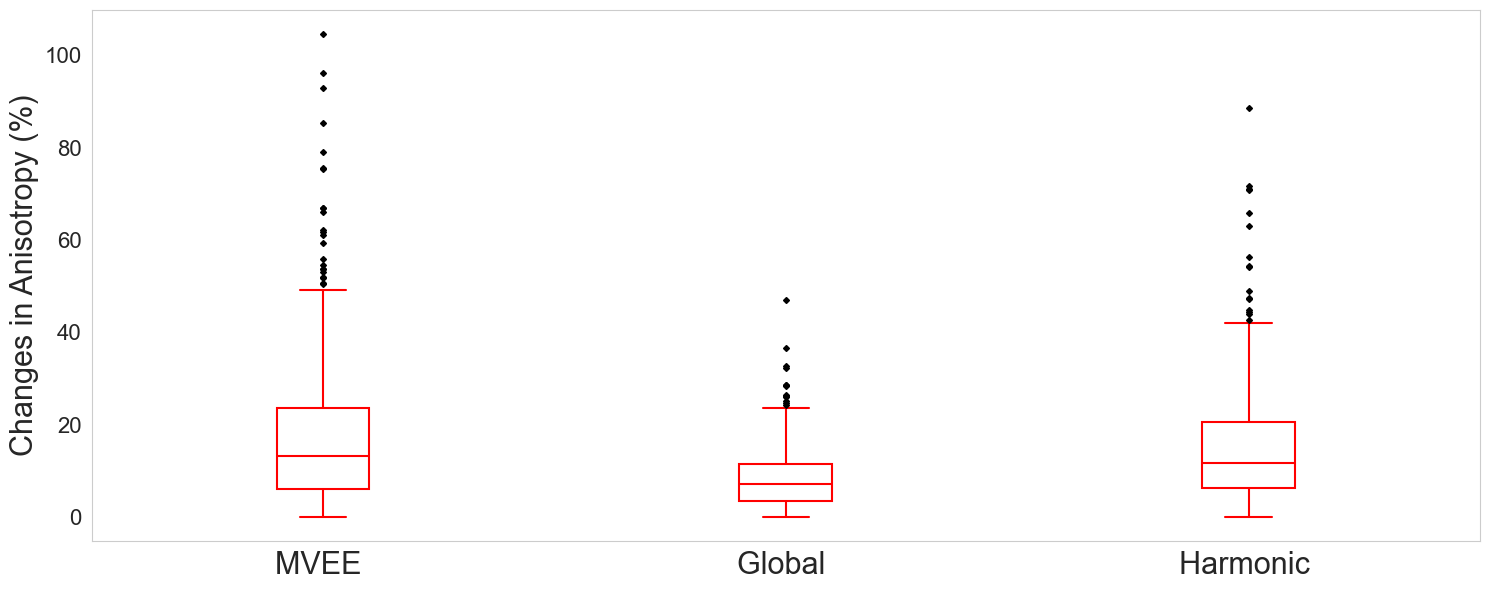

In [23]:
# Visualize major anisotropy stats
change_anisotropy_dict = {
              'MVEE ': np.array(change_mvee_anis),
              'Global ': np.array(change_global_anis),
              'Harmonic ': np.array(change_har_anis)
              }

make_boxplot(dictionary=change_anisotropy_dict, y_label="Changes in Anisotropy (%)", box_width=0.2, c_str='red')

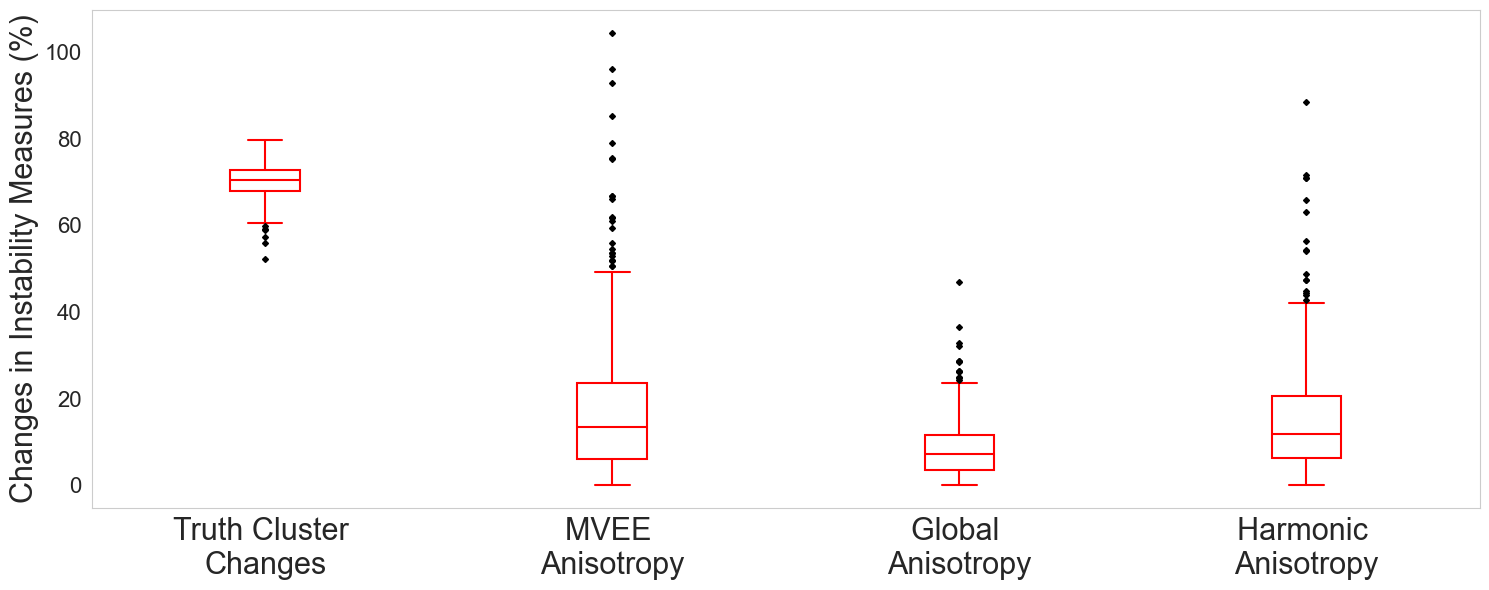

In [24]:
# Visualize changes in instability measures
instability_measures_corr_0= {
              'Truth Cluster \nChanges': np.array(change_percentages),
              'MVEE \nAnisotropy': np.array(change_mvee_anis),
              'Global \nAnisotropy': np.array(change_global_anis),
              'Harmonic \nAnisotropy': np.array(change_har_anis),
              }

make_boxplot(dictionary=instability_measures_corr_0, y_label="Changes in Instability Measures (%)", box_width=0.2, c_str='red')

In [25]:
# Visualize instability on a data point basis across multiple latent spaces for the same data index
# Function to normalize data using Min-Max scaling to the range [0, 1]
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

selected_indices = [890, 45] # User-specified indices
# selected_indices = list(range(0, 1000)) # for all realizations

# Process the user-specified indices in the first column
with h5py.File(hdf5_file, 'r') as file:
    # Normalize each dataset on [0, 1] since they are in same order already
    normalized_datasets = {key: min_max_scale(file[key][:]) for key in file.keys()}

    for i in selected_indices:
        ith_elements = [normalized_datasets[key][i, 0] for key in file.keys()]
        ith_elements_array = np.array(ith_elements)

        # Make figure for each histogram
        fig, ax = plt.subplots(figsize=(5, 4))
        optimal_bin_i = knuth_bin_width(ith_elements_array)
        ax.hist(ith_elements_array, bins=optimal_bin_i, color='red')
        ax.set_title(f'Data Index {i}')
        ax.set_xlabel('Normalized Value in LS 1')
        ax.set_ylabel('Frequency')
        ax.set_xlim([0, 1]) 
        plt.tight_layout()

        plt.savefig(f'Data Index {i} Visualization as Histogram.tiff', dpi=300, bbox_inches='tight')
        plt.close(fig)

## Better Figures

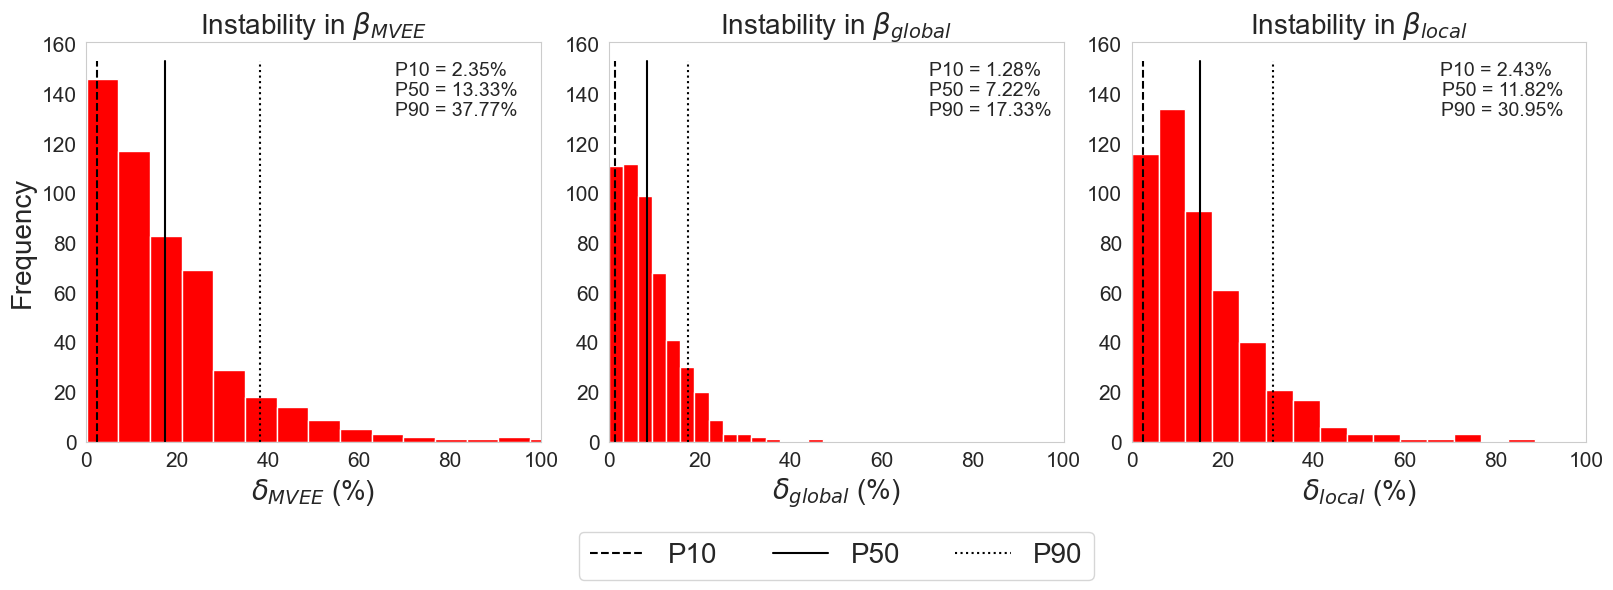

In [40]:
# Find optimal bins for each stats
optimal_bin1 = knuth_bin_width(change_mvee_anis)
optimal_bin2 = knuth_bin_width(change_global_anis)
optimal_bin3 = knuth_bin_width(change_har_anis)

# Compute histogram data
hist_data_1, _ = np.histogram(change_mvee_anis, bins=optimal_bin1)
hist_data_2, _ = np.histogram(change_global_anis, bins=optimal_bin2)
hist_data_3, _ = np.histogram(change_har_anis, bins=optimal_bin3)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2), max(hist_data_3))
overall_max_freq += overall_max_freq * 0.05

# Calculate percentiles for each dataset
p10_mvee = np.percentile(change_mvee_anis, 10)
p50_mvee = np.percentile(change_mvee_anis, 50)
p90_mvee = np.percentile(change_mvee_anis, 90)

p10_global = np.percentile(change_global_anis, 10)
p50_global = np.percentile(change_global_anis, 50)
p90_global = np.percentile(change_global_anis, 90)

p10_har = np.percentile(change_har_anis, 10)
p50_har = np.percentile(change_har_anis, 50)
p90_har = np.percentile(change_har_anis, 90)

# Set the position for the annotations
xpos = 0.95
ypos_start = 0.95
y_offset = 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 4)) #-o #8,4 ?
axs[0].hist(change_mvee_anis, bins=optimal_bin1, color='red', edgecolor='white')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin1, values=change_mvee_anis,weights=np.ones(len(change_mvee_anis)), color='black', max_freq_override=overall_max_freq)
axs[0].set_xlabel(r'$\delta_{MVEE}$ (%)', fontsize= 20)
axs[0].set_ylabel('Frequency', fontsize= 20)
axs[0].set_title("Instability in $\\beta_{MVEE}$", fontsize= 20)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].set_xlim([0, 100])  # Set x-axis limits

axs[1].hist(change_global_anis, bins=optimal_bin2, color='red', edgecolor='white')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin2, values=change_global_anis,weights=np.ones(len(change_global_anis)),color='black', max_freq_override=overall_max_freq)
axs[1].set_xlabel(r'$\delta_{global}$ (%)', fontsize= 20)
axs[1].set_title("Instability in $\\beta_{global}$", fontsize= 20)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].tick_params(axis='both', labelsize=15)
axs[1].set_xlim([0, 100])  # Set x-axis limits

axs[2].hist(change_har_anis, bins=optimal_bin3, color='red', edgecolor='white') # based off F1 score computation INSPO!
histogram_bounds(ax_or_plt=axs[2], optimal_bin=optimal_bin3, values=change_har_anis,weights=np.ones(len(change_har_anis)),color='black', max_freq_override=overall_max_freq)
axs[2].set_xlabel(r'$\delta_{local}$ (%)', fontsize= 20)
axs[2].set_title("Instability in $\\beta_{local}$", fontsize= 20)
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].tick_params(axis='both', labelsize=15)
axs[2].set_xlim([0, 100])  # Set x-axis limits


# Add annotations to the first subplot
axs[0].text(xpos-0.025, ypos_start, f'P10 = {p10_mvee:.2f}%', transform=axs[0].transAxes, ha='right', va='top', fontsize=14)
axs[0].text(xpos, ypos_start - y_offset, f'P50 = {p50_mvee:.2f}%', transform=axs[0].transAxes, ha='right', va='top', fontsize=14)
axs[0].text(xpos, ypos_start - 2*y_offset, f'P90 = {p90_mvee:.2f}%', transform=axs[0].transAxes, ha='right', va='top', fontsize=14)

# Add annotations to the second subplot
axs[1].text(xpos, ypos_start, f'P10 = {p10_global:.2f}%', transform=axs[1].transAxes, ha='right', va='top', fontsize=14)
axs[1].text(xpos, ypos_start - y_offset, f'P50 = {p50_global:.2f}%', transform=axs[1].transAxes, ha='right', va='top', fontsize=14)
axs[1].text(xpos+0.025, ypos_start - 2*y_offset, f'P90 = {p90_global:.2f}%', transform=axs[1].transAxes, ha='right', va='top', fontsize=14)

# Add annotations to the third subplot
axs[2].text(xpos-0.025, ypos_start, f'P10 = {p10_har:.2f}%', transform=axs[2].transAxes, ha='right', va='top', fontsize=14)
axs[2].text(xpos, ypos_start - y_offset, f'P50 = {p50_har:.2f}%', transform=axs[2].transAxes, ha='right', va='top', fontsize=14)
axs[2].text(xpos, ypos_start - 2*y_offset, f'P90 = {p90_har:.2f}%', transform=axs[2].transAxes, ha='right', va='top', fontsize=14)


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.08), ncol=3, fontsize=20)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.15, hspace=0.3)
plt.savefig('Modified Instability in Anisotropy-ratio-based Statistics2.tiff', dpi=300, bbox_inches='tight')
plt.show()

In [173]:
# Calculate anisotropy ratio based percentiles measure of stability
percentiles_mvee = np.percentile(change_mvee_anis, [10, 50, 90])
percentiles_global = np.percentile(change_global_anis, [10, 50, 90])
percentiles_har = np.percentile(change_har_anis, [10, 50, 90])

print(f"P10, P50, P90 for δ_MVEE: {percentiles_mvee[0]:.2f}%, {percentiles_mvee[1]:.2f}%, {percentiles_mvee[2]:.2f}%")
print(f"P10, P50, P90 for δ_global: {percentiles_global[0]:.2f}%, {percentiles_global[1]:.2f}%, {percentiles_global[2]:.2f}%")
print(f"P10, P50, P90 for δ_harmonic: {percentiles_har[0]:.2f}%, {percentiles_har[1]:.2f}%, {percentiles_har[2]:.2f}%")

P10, P50, P90 for δ_MVEE: 2.35%, 13.33%, 37.77%
P10, P50, P90 for δ_global: 1.28%, 7.22%, 17.33%
P10, P50, P90 for δ_harmonic: 2.43%, 11.82%, 30.95%


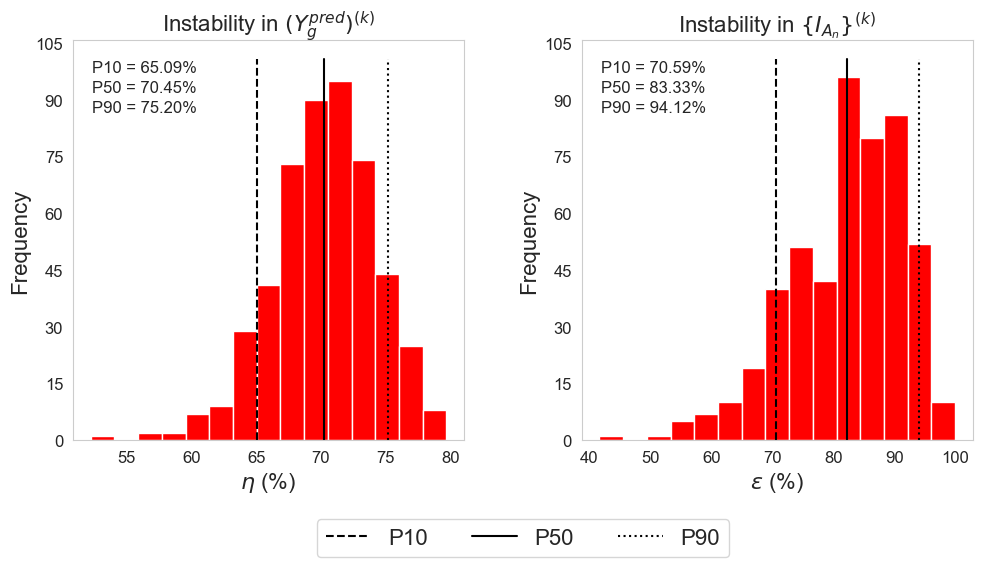

In [46]:
# Find optimal bins for each stats
optimal_bin = knuth_bin_width(change_percentages)
optimal_bin_ = knuth_bin_width(change_anchors)


# Compute histogram data
hist_data_1, _ = np.histogram(change_percentages, bins=optimal_bin)
hist_data_2, _ = np.histogram(change_anchors, bins=optimal_bin_)

# Obtain the maximum frequency from all histogram data since the sample size is same for each metric i.e. 1000 AE realizations
overall_max_freq = max(max(hist_data_1), max(hist_data_2))
overall_max_freq += overall_max_freq * 0.05

# Calculate percentiles for each dataset
p10_eta = np.percentile(change_percentages, 10)
p50_eta = np.percentile(change_percentages, 50)
p90_eta = np.percentile(change_percentages, 90)

p10_vareps = np.percentile(change_anchors, 10)
p50_vareps = np.percentile(change_anchors, 50)
p90_vareps = np.percentile(change_anchors, 90)

# Set the position for the annotations
xpos = 0.05
ypos_start = 0.95
y_offset = 0.05

# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 2, figsize=(6, 4)) #-o #8,4 ?
axs[0].hist(change_percentages, bins=optimal_bin, color='red', edgecolor='white')
histogram_bounds(ax_or_plt=axs[0], optimal_bin=optimal_bin, values=change_percentages,weights=np.ones(len(change_percentages)), color='black', max_freq_override=overall_max_freq)
axs[0].set_xlabel(r'$\eta$ (%)', fontsize= 16)
axs[0].set_ylabel('Frequency', fontsize= 16)
axs[0].set_title("Instability in $(Y_{g}^{pred})^{(k)}$", fontsize= 16)
axs[0].tick_params(axis='both', labelsize=12)
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].hist(change_anchors, bins=optimal_bin_, color='red', edgecolor='white')
histogram_bounds(ax_or_plt=axs[1], optimal_bin=optimal_bin_, values=change_anchors,weights=np.ones(len(change_anchors)), color='black', max_freq_override=overall_max_freq)
axs[1].set_xlabel(r'$\varepsilon$ (%)', fontsize= 16)
axs[1].set_ylabel('Frequency', fontsize= 16)
axs[1].set_title(r'Instability in $\{I_{A_n}\}^{(k)}$', fontsize= 16)
axs[1].tick_params(axis='both', labelsize=12)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

# Add annotations to the first subplot
axs[0].text(xpos, ypos_start, f'P10 = {p10_eta:.2f}%', transform=axs[0].transAxes, ha='left', va='top', fontsize=12)
axs[0].text(xpos, ypos_start - y_offset, f'P50 = {p50_eta:.2f}%', transform=axs[0].transAxes, ha='left', va='top', fontsize=12)
axs[0].text(xpos, ypos_start - 2*y_offset, f'P90 = {p90_eta:.2f}%', transform=axs[0].transAxes, ha='left', va='top', fontsize=12)

# Add annotations to the second subplot
axs[1].text(xpos, ypos_start, f'P10 = {p10_vareps:.2f}%', transform=axs[1].transAxes, ha='left', va='top', fontsize=12)
axs[1].text(xpos, ypos_start - y_offset, f'P50 = {p50_vareps:.2f}%', transform=axs[1].transAxes, ha='left', va='top', fontsize=12)
axs[1].text(xpos, ypos_start - 2*y_offset, f'P90 = {p90_vareps:.2f}%', transform=axs[1].transAxes, ha='left', va='top', fontsize=12)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:3], labels[:3], loc='lower center', bbox_to_anchor=(0.75, -0.02), ncol=3, fontsize=16)

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.30, hspace=0.3)
plt.savefig('Modified Instability in Shape-based Statistics2.tiff', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
# Calculate percentiles for change_percentages
percentiles_percentages = np.percentile(change_percentages, [10, 50, 90])

# Calculate percentiles for change_anchors
percentiles_anchors = np.percentile(change_anchors, [10, 50, 90])

print(f"P10, P50, P90 for η (%): {percentiles_percentages[0]:.2f}%, {percentiles_percentages[1]:.2f}%, {percentiles_percentages[2]:.2f}%")
print(f"P10, P50, P90 for ε (%): {percentiles_anchors[0]:.2f}%, {percentiles_anchors[1]:.2f}%, {percentiles_anchors[2]:.2f}%")

P10, P50, P90 for η (%): 65.09%, 70.45%, 75.20%
P10, P50, P90 for ε (%): 70.59%, 83.33%, 94.12%


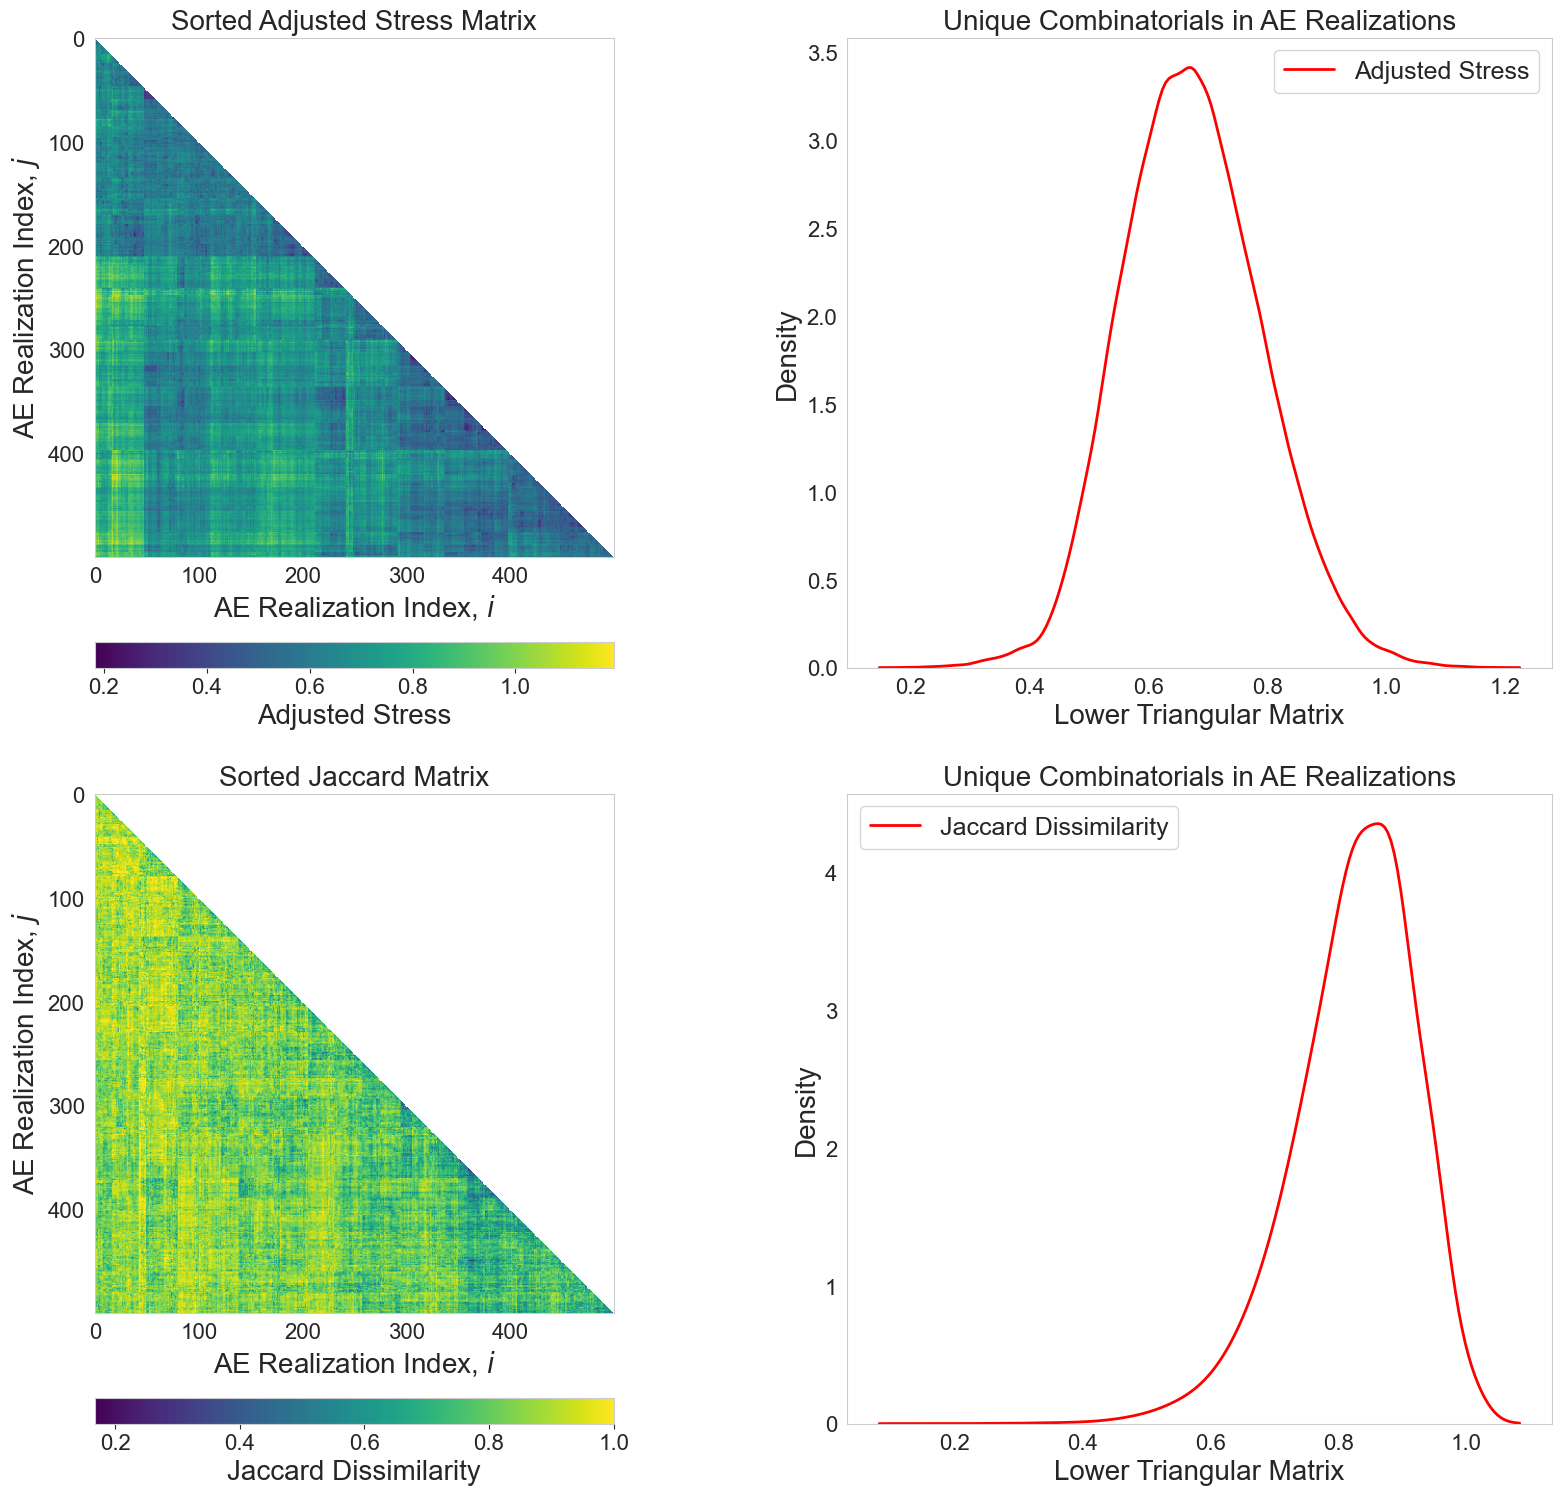

Mode for adjusted stress: 0.6674
Mode for Jaccard dissimilarity: 0.8625


In [48]:
# Compute and Visualize stress measures
ordered_dist_mat1, res_order1, res_linkage1 = compute_serial_matrix(adjusted_stress_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle1 = np.tril(ordered_dist_mat1, k=-1) # Adjusted stress
upper_triangle_mask = np.triu(np.ones(ordered_dist_mat1.shape), k=0).astype(bool)
lower_triangle1[upper_triangle_mask] = np.nan
flatten_data1 = lower_triangle1[~np.isnan(lower_triangle1)]

# Compute and Visualize Jaccard similarity measures
ordered_dist_mat2, res_order2, res_linkage2 = compute_serial_matrix(similarity_matrix,"ward")

# Extract the lower triangular matrix for the sorted stress matrices excluding diagonal and visualize via kde
lower_triangle2 = np.tril(ordered_dist_mat2, k=-1) # Jaccard similarity
upper_triangle_mask = np.triu(np.ones(ordered_dist_mat2.shape), k=0).astype(bool)
lower_triangle2[upper_triangle_mask] = np.nan
flatten_data2 = lower_triangle2[~np.isnan(lower_triangle2)]

# make jaccard dissimilarity i.e., 1-similarity 
lower_triangle2 = 1-lower_triangle2
flatten_data2 = lower_triangle2[~np.isnan(lower_triangle2)]

# # Save stress and jaccard values to numpy arrays
# np.save('jaccard_array_corr_0.npy', flatten_data2)
# np.save('stress_array_corr_0.npy', flatten_data1)

fig, axs = plt.subplots(2, 2, figsize=(20, 18)) # orange and purple
# Sorted Adjusted Stress - lower triangle matrix excluding diagonal
im1 = axs[0, 0].imshow(lower_triangle1, cmap="viridis")
axs[0, 0].set_title("Sorted Adjusted Stress Matrix", size=20)
axs[0, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[0, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[0, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Adjusted Stress', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of adjusted stress excluding the diagonal
sns.kdeplot(flatten_data1, ax=axs[0, 1], color='red', label='Adjusted Stress', linewidth=2)
axs[0, 1].set_title("Unique Combinatorials in AE Realizations", size=20) # MIDE
axs[0, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[0, 1].set_ylabel('Density', fontsize=20)
axs[0, 1].tick_params(labelsize=16)
axs[0, 1].legend(fontsize=18)

# Sorted Adjusted Jaccard - lower triangle matrix excluding diagonal
im1 = axs[1, 0].imshow(lower_triangle2, cmap="viridis")
axs[1, 0].set_title("Sorted Jaccard Matrix", size=20)
axs[1, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[1, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[1, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Jaccard Dissimilarity', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of Jaccard excluding the diagonal
sns.kdeplot(flatten_data2, ax=axs[1, 1], bw_method=0.3, color='red', label='Jaccard Dissimilarity', linewidth=2)
axs[1, 1].set_title("Unique Combinatorials in AE Realizations", size=20) # MIDE
axs[1, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[1, 1].set_ylabel('Density', fontsize=20)
axs[1, 1].tick_params(labelsize=16)
axs[1, 1].legend(fontsize=18)

# Customization
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Combined Stress and Jaccard Analysis.tiff', dpi=300, bbox_inches='tight')
plt.show()

# Assuming axs[0, 1] contains the KDE plot for adjusted stress
line_stress = axs[0, 1].get_lines()[0]  # Get the first (and likely only) line in the plot
x_data_stress, y_data_stress = line_stress.get_data()
mode_stress = x_data_stress[np.argmax(y_data_stress)]

# Assuming axs[1, 1] contains the KDE plot for Jaccard similarity
line_jaccard = axs[1, 1].get_lines()[0]  # Get the first (and likely only) line in the plot
x_data_jaccard, y_data_jaccard = line_jaccard.get_data()
mode_jaccard = x_data_jaccard[np.argmax(y_data_jaccard)]

# Print the mode values
print(f"Mode for adjusted stress: {mode_stress:.4f}")
print(f"Mode for Jaccard dissimilarity: {mode_jaccard:.4f}")

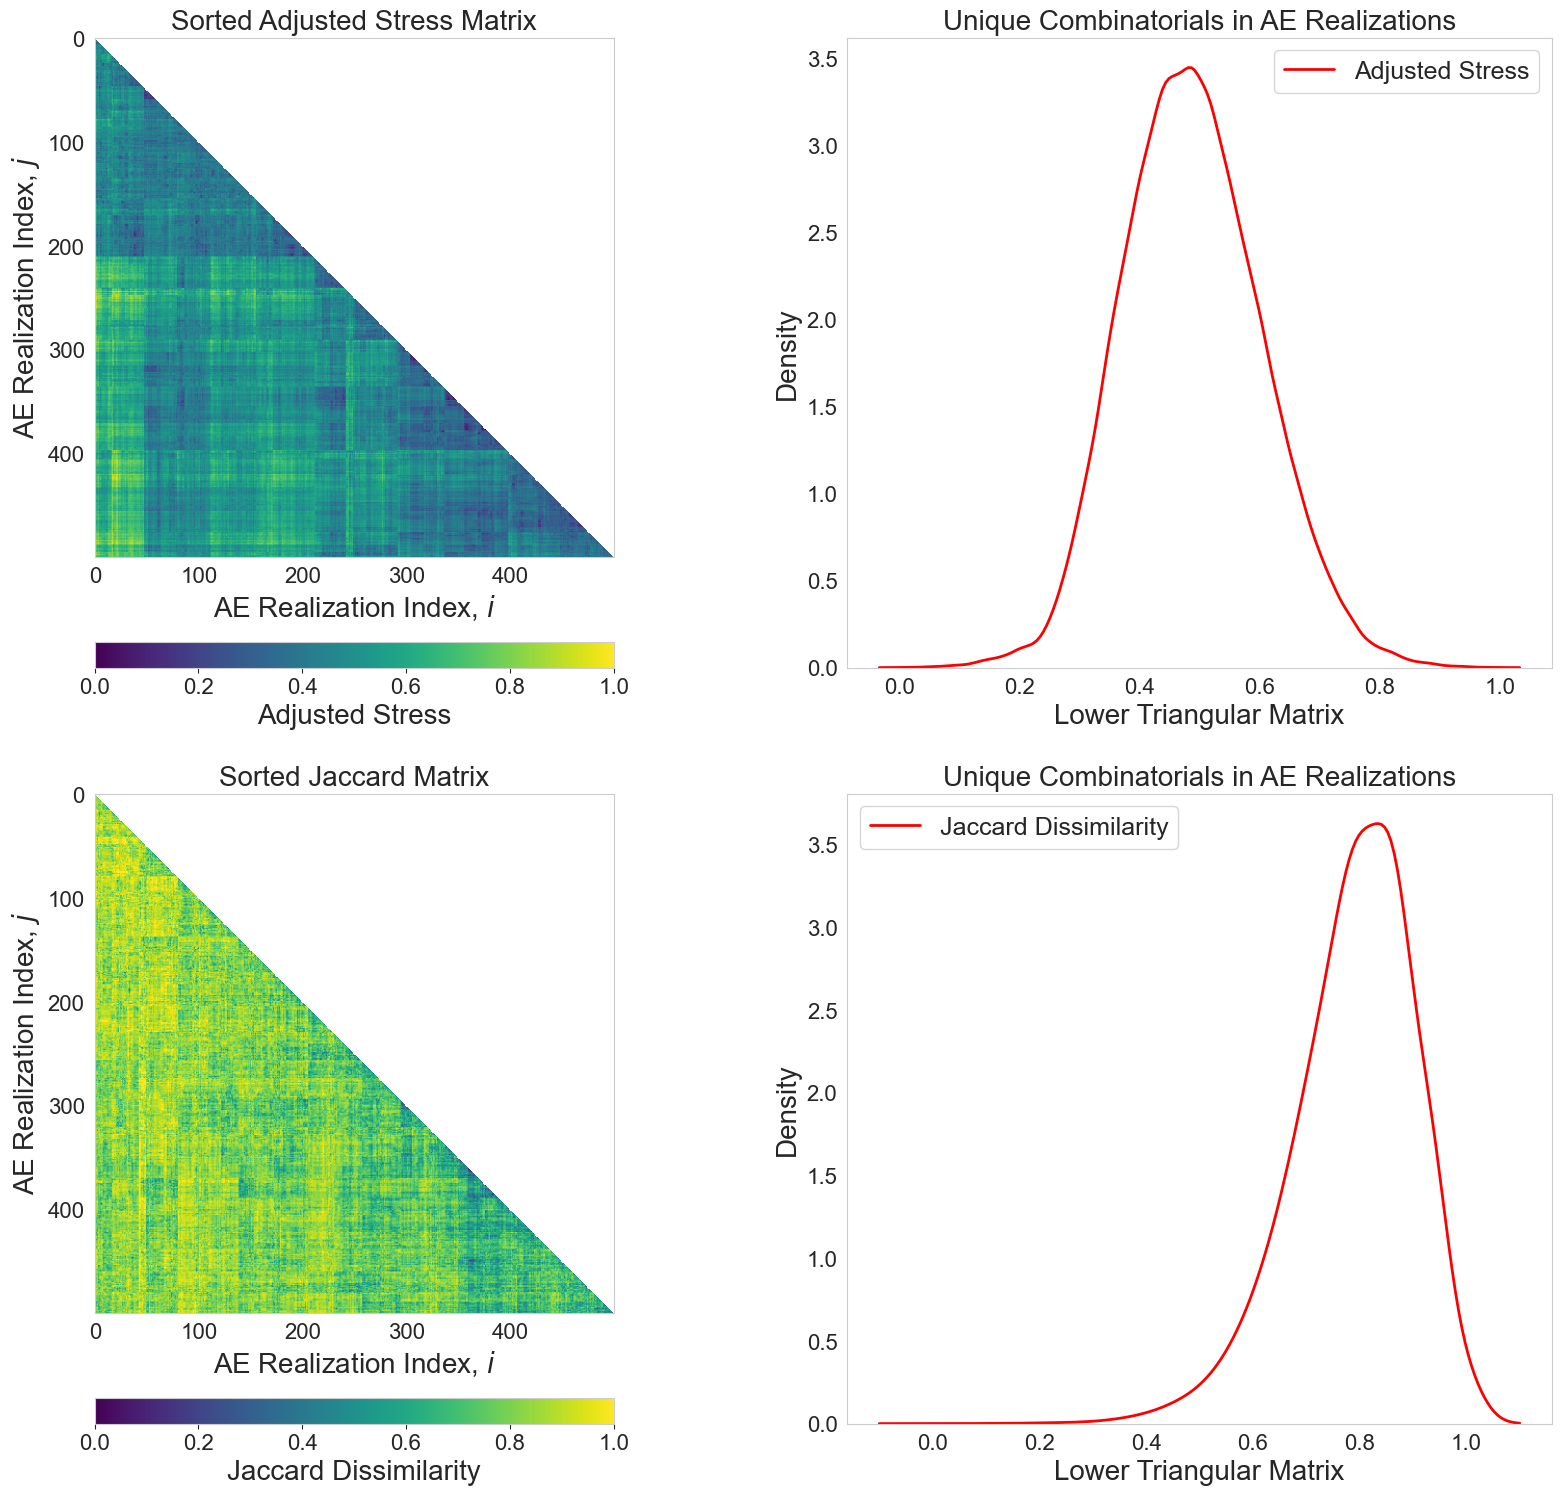

Mode for adjusted stress: 0.4812
Mode for Jaccard dissimilarity: 0.8350


In [49]:
# normalized adjusted stress
lower_triangle1_normalized = (lower_triangle1 - np.nanmin(lower_triangle1)) / (np.nanmax(lower_triangle1) - np.nanmin(lower_triangle1))
flatten_data1_normalized = (flatten_data1 - np.min(flatten_data1)) / (np.max(flatten_data1) - np.min(flatten_data1))

# normalized jaccard
lower_triangle2_normalized = (lower_triangle2 - np.nanmin(lower_triangle2)) / (np.nanmax(lower_triangle2) - np.nanmin(lower_triangle2))
flatten_data2_normalized = (flatten_data2 - np.min(flatten_data2)) / (np.max(flatten_data2) - np.min(flatten_data2))

# # Save stress and jaccard values to numpy arrays
# np.save('jaccard_array_corr_0_norm.npy', flatten_data2_normalized)
# np.save('stress_array_corr_0_norm.npy', flatten_data1_normalized)


fig, axs = plt.subplots(2, 2, figsize=(20, 18)) # orange and purple
# Sorted Adjusted Stress - lower triangle matrix excluding diagonal
im1 = axs[0, 0].imshow(lower_triangle1_normalized, cmap="viridis", vmin=0, vmax=1)
axs[0, 0].set_title("Sorted Adjusted Stress Matrix", size=20)
axs[0, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[0, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[0, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Adjusted Stress', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of adjusted stress excluding the diagonal
sns.kdeplot(flatten_data1_normalized, ax=axs[0, 1], color='red', label='Adjusted Stress', linewidth=2)
axs[0, 1].set_title("Unique Combinatorials in AE Realizations", size=20) # MIDE
axs[0, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[0, 1].set_ylabel('Density', fontsize=20)
axs[0, 1].tick_params(labelsize=16)
axs[0, 1].legend(fontsize=18)

# Sorted Adjusted Jaccard - lower triangle matrix excluding diagonal
im1 = axs[1, 0].imshow(lower_triangle2_normalized, cmap="viridis", vmin=0, vmax=1)
axs[1, 0].set_title("Sorted Jaccard Matrix", size=20)
axs[1, 0].set_xlabel("AE Realization Index, $i$", size=20)
axs[1, 0].set_ylabel("AE Realization Index, $j$", size=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
# Aesthetics
divider = make_axes_locatable(axs[1, 0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Jaccard Dissimilarity', size=20)
cbar1.ax.tick_params(labelsize=16)

# KDE of lower triangular matrix of Jaccard excluding the diagonal
sns.kdeplot(flatten_data2_normalized, ax=axs[1, 1], bw_method=0.3, color='red', label='Jaccard Dissimilarity', linewidth=2)
axs[1, 1].set_title("Unique Combinatorials in AE Realizations", size=20) # MIDE
axs[1, 1].set_xlabel('Lower Triangular Matrix', fontsize=20)
axs[1, 1].set_ylabel('Density', fontsize=20)
axs[1, 1].tick_params(labelsize=16) 
axs[1, 1].legend(fontsize=18)

# Customization
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('Combined Stress and Jaccard Analysis v2.tiff', dpi=300, bbox_inches='tight')
plt.show()

# Assuming axs[0, 1] contains the KDE plot for adjusted stress
line_stress = axs[0, 1].get_lines()[0]  # Get the first (and likely only) line in the plot
x_data_stress, y_data_stress = line_stress.get_data()
mode_stress = x_data_stress[np.argmax(y_data_stress)]

# Assuming axs[1, 1] contains the KDE plot for Jaccard similarity
line_jaccard = axs[1, 1].get_lines()[0]  # Get the first (and likely only) line in the plot
x_data_jaccard, y_data_jaccard = line_jaccard.get_data()
mode_jaccard = x_data_jaccard[np.argmax(y_data_jaccard)]

# Print the mode values
print(f"Mode for adjusted stress: {mode_stress:.4f}")
print(f"Mode for Jaccard dissimilarity: {mode_jaccard:.4f}")